# Business Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 6g --executor-memory 6g
```

The general plan is to do some exploration and cleaning in jupyter notebooks, then run our actual models by submitting python scripts and letting the jobs run as we'd expect.

We'll clean the data and load them into cassandra tables to be used by the jobs.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import isnull, count, datediff, lag, sum, coalesce, rank, lit, when,col, udf, to_date, year, mean, month, date_format, array
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.ml.feature import StringIndexer
from datetime import datetime
from pyspark.sql.window import Window
import pyspark
import matplotlib
import matplotlib.pyplot as plt

Again, we load the file into DSEFS (DSE's Hadoop implementation).

```bash
./dse fs
mkdir datadir
put /Users/angelo/chicago/data/Business_Licenses_-_Current_Active.csv datadir/Business_Licenses_-_Current_Active.csv

```

Now, we can start working with it... let's load it into the spark context

In [36]:
df = sqlContext.read.csv("dsefs:///datadir/Business_Licenses_-_Current_Active.csv", sep="^", header="True")

In [37]:
df = df.filter((col("Application Type") != "C_CAPA") & (col("Application Type") != "C_SBA") & \
              (col("License Term Start Date").isNotNull()) & (col("License Term Expiration Date").isNotNull()))

In [38]:
df = df.withColumn("latitude", col("LATITUDE").cast("float")) \
        .withColumn("longitude", col("LONGITUDE").cast("float")) \
        .drop("LOCATION")

In [39]:
print "Shape of the data: ", df.count()
print "Available data:\n", df.columns
# View first few rows
df_businesses = df.toPandas()
df_businesses.head()

Shape of the data:  63524
Available data:
['ID', 'LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME', 'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP CODE', 'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE DESCRIPTION', 'BUSINESS ACTIVITY ID', 'BUSINESS ACTIVITY', 'LICENSE NUMBER', 'APPLICATION TYPE', 'APPLICATION CREATED DATE', 'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE', 'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE', 'LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE', 'DATE ISSUED', 'LICENSE STATUS', 'LICENSE STATUS CHANGE DATE', 'SSA', 'latitude', 'longitude']


,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,CONDITIONAL APPROVAL,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,latitude,longitude
0,1620668-20160516,2455262,295026,1,BUCCI BIG & TALL INC.,BUCCI BIG & TALL INC.,558 W ROOSEVELT RD,CHICAGO,IL,60607,...,N,05/16/2016,05/15/2018,05/18/2016,08/30/2016,AAI,None,None,41.867340,-87.641586
1,2488345-20160830,2488345,409564,1,"BURKS HEATING AND COOLING SOLUTIONS, LLC","BURKS HEATING AND COOLING SOLUTIONS, LLC",5722 S WOOD ST 1ST,CHICAGO,IL,60636,...,N,08/30/2016,09/15/2018,08/30/2016,08/30/2016,AAI,None,None,41.789616,-87.669472
2,2279620-20160830,2279620,305598,17,"PREFER VALET PARKING SERVICE, INC.","PREFER VALET PARKING SERVICES, INC.",2812-2840 W 26TH ST GROUND,CHICAGO,IL,60623,...,N,08/30/2016,03/15/2018,08/30/2016,08/30/2016,AAI,None,25,41.844791,-87.695740
3,2354707-20160916,2482568,393149,1,ANGELINE R. MC CARTHY,ANGELINE R. MC CARTHY,17707 S HARLEM ST 1,TINLEY PARK,IL,60477,...,N,09/16/2016,09/15/2018,None,08/30/2016,AAI,None,None,NaN,NaN
4,1677226-20151116,2426071,300195,1,"CORNERSTONE CAFE', INC.",CORNERSTONE CAFE,2753 N WESTERN AVE,CHICAGO,IL,60647,...,N,11/16/2015,11/15/2017,11/09/2015,11/10/2015,AAI,None,None,41.931969,-87.687744


In [40]:
#--------  Scatter Plot
# A function that visualizes the data
# Input: 
#      x (variable on the x-axis)
#      y (variable on the y_axis)
#      df (panda data frame)
#      group (grouping variable, i.e., variable to plot)
#      col (vector of colors)
#      alpha (alpha value for colors)
#      size (size of the dots)
#      title (title of the plot)
#      marker (shape of the marker, default to 'o')
#      add_line (add a line plot)
#      linewidth (thinkness of the added line)
#      figsize (size of the figure)

def scatter_plot(x, y, my_df, group, colors, alpha, size, title, marker='o', add_line=False, linewidth=1, figsize=(15, 10)):
    
    # Define plot
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # Extract unique categories
    cat = my_df[group].unique()

    # Loop trough categories
    for i in range(0, len(cat)) :
            ax.scatter(my_df[x][my_df[group] == cat[i]].values,
                       my_df[y][my_df[group] == cat[i]].values,
                       alpha=alpha, edgecolors="None", s=size,
                       label=cat[i],
                       marker=marker)
    # Add line plot
    if add_line:
            for i in range(0, len(cat)) :
                ax.plot(my_df[x][my_df[group] == cat[i]].values,
                           my_df[y][my_df[group] == cat[i]].values,
                           alpha=alpha, linewidth=linewidth)

    # Add legend, grid etc.
    ax.legend(loc=0, scatterpoints = 1) # Legend with just one dot
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(title)
    plt.grid()

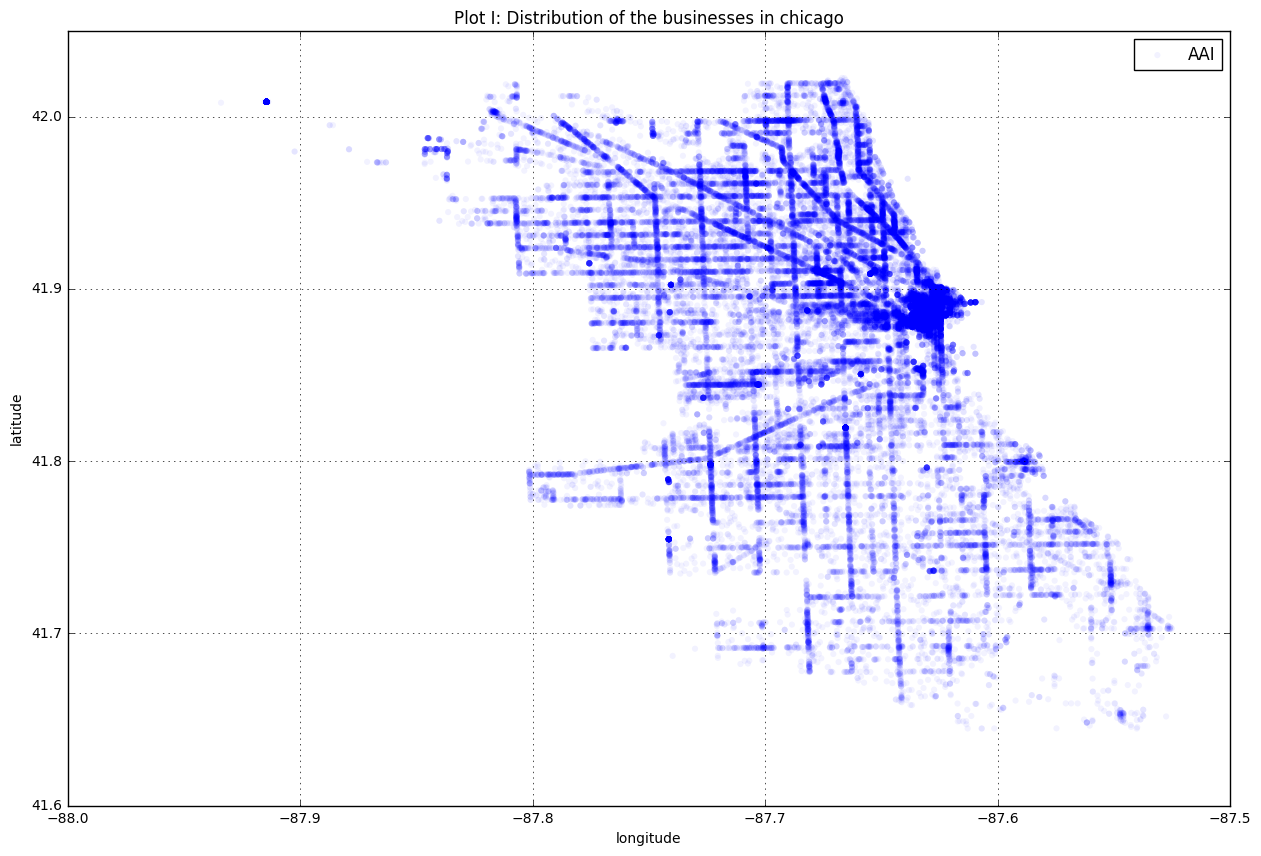

In [41]:
# Plot the data
scatter_plot(x='longitude', y='latitude', my_df=df_businesses, group='LICENSE STATUS',
             colors=["darkblue", "darkred", "black"], alpha=0.05, size=20, marker='o', figsize=(15, 10),
             title="Plot I: Distribution of the businesses in chicago")

This gives us an interesting view of the data, but pretty much what we'd expect. More restaurants near downtown and major roadways.

In [42]:

#--------  Bar Plot
# A function to create a barplot
# Input: 
#      df (panda data frame)
#      var_name (name of the variable)
#      alpha (alpha value [0, 1])
#      title (title of the function)
#      color (color of the barplot)
#      edgecolor (cor of the outer barplotlines)
#      figsize (size of the figure)

def bar_plot(my_df, var_name, color='darkblue', alpha=0.6, title='', edgecolor='white', figsize=(18, 6)):
    
    ## Analyse crime types
    my_df['count'] = 1
    group = my_df.groupby(var_name)
    group = group.sum()
    group = group.sort_values('count', ascending=False)
    group = group['count']

    # Plot
    plt = group.plot(kind='bar', figsize=figsize, color=color, alpha=alpha, edgecolor=edgecolor, title=title)
    plt.grid()

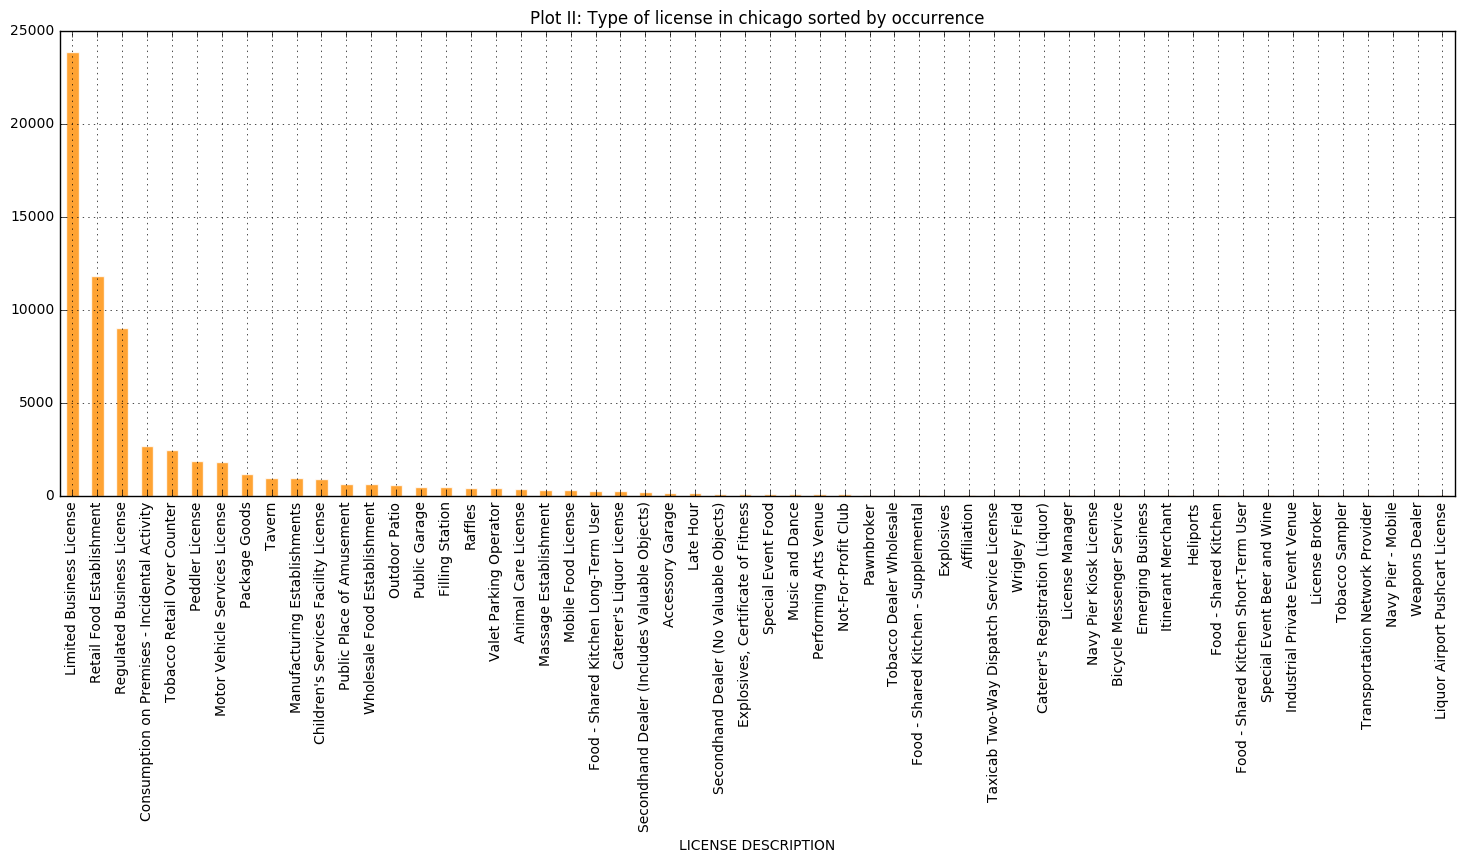

In [43]:
bar_plot(my_df=df_businesses, var_name='LICENSE DESCRIPTION', color='darkorange', alpha=0.8,
         title='Plot II: Type of license in chicago sorted by occurrence', edgecolor='white', figsize=(18, 6))

Most licenses are a limited business license and for food retail. So, there's lots of eating establishments.

In [44]:
df.dtypes

[('ID', 'string'),
 ('LICENSE ID', 'string'),
 ('ACCOUNT NUMBER', 'string'),
 ('SITE NUMBER', 'string'),
 ('LEGAL NAME', 'string'),
 ('DOING BUSINESS AS NAME', 'string'),
 ('ADDRESS', 'string'),
 ('CITY', 'string'),
 ('STATE', 'string'),
 ('ZIP CODE', 'string'),
 ('WARD', 'string'),
 ('PRECINCT', 'string'),
 ('WARD PRECINCT', 'string'),
 ('POLICE DISTRICT', 'string'),
 ('LICENSE CODE', 'string'),
 ('LICENSE DESCRIPTION', 'string'),
 ('BUSINESS ACTIVITY ID', 'string'),
 ('BUSINESS ACTIVITY', 'string'),
 ('LICENSE NUMBER', 'string'),
 ('APPLICATION TYPE', 'string'),
 ('APPLICATION CREATED DATE', 'string'),
 ('APPLICATION REQUIREMENTS COMPLETE', 'string'),
 ('PAYMENT DATE', 'string'),
 ('CONDITIONAL APPROVAL', 'string'),
 ('LICENSE TERM START DATE', 'string'),
 ('LICENSE TERM EXPIRATION DATE', 'string'),
 ('LICENSE APPROVED FOR ISSUANCE', 'string'),
 ('DATE ISSUED', 'string'),
 ('LICENSE STATUS', 'string'),
 ('LICENSE STATUS CHANGE DATE', 'string'),
 ('SSA', 'string'),
 ('latitude', 'floa

Again, clean up the column names

In [59]:
df = df.select(col('ID').alias('id'),
 col('LICENSE ID').alias('license_id'),
 col('ACCOUNT NUMBER').alias('account_number'),
 col('SITE NUMBER').alias('site_number'),
 col('LEGAL NAME').alias('legal_name'),
 col('DOING BUSINESS AS NAME').alias('doing_business_as_name'),
 col('ADDRESS').alias('address'),
 col('ZIP CODE').alias('zip'),
 col('WARD').alias('ward'),
 col('PRECINCT').alias('precinct'),
 col('POLICE DISTRICT').alias('police_district'),
 col('LICENSE CODE').alias('license_code'),
 col('LICENSE DESCRIPTION').alias('license_description'),
 col('BUSINESS ACTIVITY ID').alias('business_activity_id'),
 col('BUSINESS ACTIVITY').alias('business_activity'),
 col('LICENSE NUMBER').alias('license_number'),
 col('APPLICATION TYPE').alias('application_type'),
 col('APPLICATION CREATED DATE').alias('application_created_date'),
 col('APPLICATION REQUIREMENTS COMPLETE').alias('application_requirements_complete'),
 col('PAYMENT DATE').alias('payment_date'),
 col('CONDITIONAL APPROVAL').alias('conditional_approval'),
 col('LICENSE TERM START DATE').alias('license_term_start_date'),
 col('LICENSE TERM EXPIRATION DATE').alias('license_term_expiration_date'),
 col('LICENSE APPROVED FOR ISSUANCE').alias('license_approved_for_issuance'),
 col('DATE ISSUED').alias('license_status_change_date'),
 col('SSA').alias('ssa'),
 col('latitude'),
 col('longitude'))

In [61]:
df.dtypes

[('id', 'string'),
 ('license_id', 'string'),
 ('account_number', 'string'),
 ('site_number', 'string'),
 ('legal_name', 'string'),
 ('doing_business_as_name', 'string'),
 ('address', 'string'),
 ('zip', 'string'),
 ('ward', 'string'),
 ('precinct', 'string'),
 ('police_district', 'string'),
 ('license_code', 'string'),
 ('license_description', 'string'),
 ('business_activity_id', 'string'),
 ('business_activity', 'string'),
 ('license_number', 'string'),
 ('application_type', 'string'),
 ('application_created_date', 'string'),
 ('application_requirements_complete', 'string'),
 ('payment_date', 'string'),
 ('conditional_approval', 'string'),
 ('license_term_start_date', 'string'),
 ('license_term_expiration_date', 'string'),
 ('license_approved_for_issuance', 'string'),
 ('license_status_change_date', 'string'),
 ('ssa', 'string'),
 ('latitude', 'float'),
 ('longitude', 'float')]

```cql
CREATE  KEYSPACE chicago_data 
   WITH REPLICATION = {'class' : 'SimpleStrategy', 'replication_factor' : 1};
```

```cql
CREATE TABLE chicago_data.licenses (
    id text,
    license_id text,
    account_number text,
    site_number text,
    legal_name text,
    doing_business_as_name text,
    address text,
    zip text,
    ward text,
    precinct text,
    police_district text,
    license_code text,
    license_description text,
    business_activity_id text,
    business_activity text,
    license_number text,
    application_type text,
    application_created_date text,
    application_requirements_complete text,
    payment_date text,
    conditional_approval text,
    license_term_start_date text,
    license_term_expiration_date text,
    license_approved_for_issuance text,
    license_status_change_date text,
    ssa text,
    latitude float,
    longitude float,
    PRIMARY KEY (id, license_id));
```

In [63]:
 df.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="licenses", keyspace="chicago_data")\
    .save()